In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

import seaborn as sns
import numpy as np

from sklearn import set_config ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO
set_config(display = 'diagram') ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO

import joblib
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, cohen_kappa_score, accuracy_score, precision_score, recall_score, silhouette_samples, silhouette_score, calinski_harabasz_score
from  sklearn.base import clone ## Clonar un pipeline
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

In [2]:
! python --version

Python 3.11.6


In [3]:
train = pd.read_csv('Train.csv')

In [4]:
train.head(2)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [6]:
## Realizamos una copia del dataset original en caso de volver a ocupar esta versión sin cambios.
train_original = train.copy()

In [7]:
## Se verifica si hay datos duplicados
train.loc[train.duplicated()]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


In [8]:
## Se elimina la variable ID, no es relevante para el análisis
train.drop('ID', axis = 1, inplace = True)

## Limpieza y EDA

### a. Control de calidad de los datos.
En esta sección se realiza una revisión del tipo de variables y el número de datos faltantes en el data set de entrenamiento.

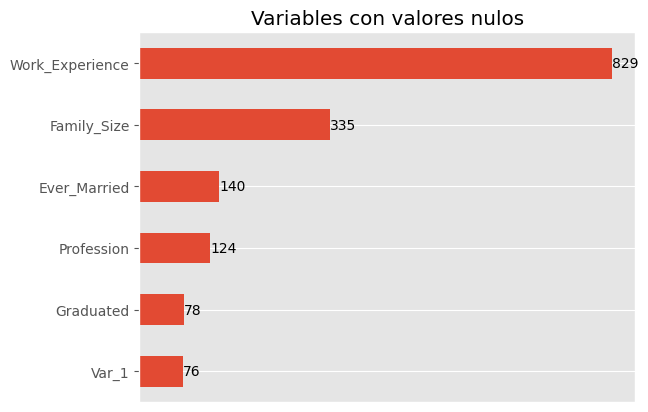

In [9]:
ax = train.isnull().sum()[train.isnull().sum()>0].sort_values().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax.set_title('Variables con valores nulos')
ax.get_xaxis().set_visible(False)
plt.show()

In [10]:
train.isnull().sum(axis = 1).value_counts()

0    6665
1    1244
2     140
3      18
4       1
Name: count, dtype: int64

* En el control de calidad de los datos, se encuentra que el dataset consta de 8.608 observaciones y 11 variables, las cuales todas tienen el tipo de variable esperado. 

* Con respecto a los datos faltantes, la variable ***Work_Experience*** es la que mayor cantidad de nulos tiene (829), seguido de ***Family_Size*** (335).

* En cuanto al número de nulos por observación se encuentra que, existen 6.665 registros completos, 1.244 registros con un dato faltante, 140 registros con datos faltantes en 2 columnas y 19 registros con al menos 3 columnas sin dato.

In [11]:
## Se define una función para obtener el índice de las variables categóricas, numéricas y variable objetivo
def SepararNumCate(df : pd.DataFrame):
    '''Returns a triplet with column names (numerical, categorical, target)
    '''
    numerical = df.select_dtypes(include = 'number').columns.to_list()
    categorical = df.select_dtypes(exclude = 'number').columns.to_list()
    categorical.remove('Segmentation') ## REMOVES THE TARGET VARIABLE
    target = ['Segmentation']
    return numerical, categorical, target


num_idx, categ_idx, target_idx = SepararNumCate(train)

In [12]:
## Identificar los valores únicos de las variables categóricas
for i in train[categ_idx + target_idx].columns:
    print(f'Categorías de la variable "{i}" ',train[i].unique(),'\n')

Categorías de la variable "Gender"  ['Male' 'Female'] 

Categorías de la variable "Ever_Married"  ['No' 'Yes' nan] 

Categorías de la variable "Graduated"  ['No' 'Yes' nan] 

Categorías de la variable "Profession"  ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan] 

Categorías de la variable "Spending_Score"  ['Low' 'Average' 'High'] 

Categorías de la variable "Var_1"  ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5'] 

Categorías de la variable "Segmentation"  ['D' 'A' 'B' 'C'] 



**Para elegir qué se va a realizar con respecto a los valores faltantes se proponen 3 estrategias:**

> - 1. Un data set de entrenamiento eliminando todos las observaciones que tengan al menos 1 dato faltante, lo que representa quedarse con un 75% del data set de entrenamiento inicial.

> - 2. Un data set de entrenamiento donde se eliminan las observaciones que tienen 2 o más datos nulos y a la observación que quede con dato un nulo se le asigna el valor, mediante algún método de imputación.

> - 3. Un data set donde no se elimina ningún registro, se asignan los valores por algún método de imputación.


**Definimos los pipelines y la función por la cual va a pasar cada uno de los dataset de las anteriores estrategias**

In [13]:
### Pipelines

numerical_pipeline = Pipeline( steps = [
    ('scaler',StandardScaler())
])

categ_pipeline = Pipeline( steps = [
    ('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

## ColumnTransformer
columnsTransf = ColumnTransformer(transformers = [
                    ('numerical_pl',numerical_pipeline,num_idx),
                    ('categorical_pl',categ_pipeline,categ_idx)
                            ],
                    remainder = 'drop'
                                )

rf_model = RandomForestClassifier(random_state = 123)
lr_model = LogisticRegression(random_state = 123)
nb_model = GaussianNB()
kn_clf_model = KNeighborsClassifier()
xgb_clf = xgb.XGBClassifier(random_state = 123)

### Diccionario que contiene todos los pipelines
pl_dict = { 'RandomForest' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',rf_model)
                                        ]),
            'LogisticRegression' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',lr_model)
                                        ]),
            'NaiveBayes' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',nb_model)
                                         ]),
            'KNeighborsClassifier' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',kn_clf_model)
                                         ]),
            'XGBClassifier' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',xgb_clf)
                                         ])                                            
           }

## Crear el pipeline para la imputación
num_imputer = Pipeline(steps = [
        ('num_imputer',SimpleImputer(strategy = 'median')),
])

cat_imputer = Pipeline(steps = [
    ('cat_imputer',SimpleImputer(strategy = 'most_frequent'))
])

columnImputer = ColumnTransformer(transformers = [
    ('Numerical',num_imputer,num_idx),
    ('Categorical', cat_imputer, categ_idx)
                                ], 
            remainder = 'passthrough' ## En este caso no se utiliza el passthrough porque necesitamos la variable objetivo, este pipeline es sólo para transformar las X's
)

imputer_pipe = Pipeline(steps=[
    ('columns_transf',columnImputer)
])

def ImputersTest(df : pd.DataFrame,  numerical_columns : list, 
                 categorical_columns : list, target : str, model : str): 
    if model in pl_dict.keys():
        pipe = clone(pl_dict.get(model))
        print(f"Accuracy with CV : {cross_val_score(pipe,df[numerical_columns + categorical_columns], df[target], cv = 5, scoring = 'accuracy').mean()}")
        return None
    else:
        print(f'{model} no es un modelo implementado, las opciones son {list(pl_dict.keys())}')

### Estrategia 1

No hacer ningún tratamiento de imputación, se eliminan las filas que contengan NA's. Se calcula el accuracy de este dataset utilizando un modelo de RandomForest.

In [14]:
train1 = train.dropna( axis = 0).copy()
ImputersTest(train1 ,num_idx, categ_idx, target_idx, 'RandomForest')

Accuracy with CV : 0.48012003000750186


### Estrategia 2

Se eliminan las observaciones que tienen 2 o más datos nulos y a la observación que quede con dato un nulo se le asigna el valor, mediante algún método de imputación. Se calcula el accuracy utilizando un modelo de RandomForest.


In [15]:
## Se eliminan las filas que tienen datos faltantes en 2 o más de sus columnas
train2 = train.drop(train.loc[train.isna().sum(axis = 1) >= 2].index).copy()

## Se almacena el imputador de las variables, por si se debe usar en los datos de prueba.
imput_str2 = clone(imputer_pipe)
imput_str2.fit(train2)
train2_imp = pd.DataFrame(imput_str2.transform(train2), columns = num_idx + categ_idx + target_idx)
ImputersTest(train2_imp,num_idx,categ_idx,target_idx,'RandomForest')

Accuracy with CV : 0.48173082535897604


### Estrategia 3
No se elimina ningún registro, se asignan los valores faltantes por algún método de imputación. Se calcula el accuracy utilizando un modelo de RandomForest.

In [16]:
train3 = train.copy()

## Se almacena el imputador de las variables, por si se debe usar en los datos de prueba.
imput_str3 = clone(imputer_pipe)
imput_str3.fit(train3)
train3_imp = pd.DataFrame(imput_str3.transform(train3), columns = num_idx + categ_idx + target_idx)
ImputersTest(train3_imp,num_idx,categ_idx,target_idx,'RandomForest')

Accuracy with CV : 0.476822763620552


* De las 3 estrategias propuestas y evaluadas, todas presentaron un accuracy similar, no obstante si se eliminan todos los datos faltantes (estrategia 1) se perdería alrededor del 17% de las observaciones, mientras que si se eliminan sólo aquellos registros cuyas observaciones tengan nulos en 2 o más variables se perdería alrededor del 2% del dataset original. Por lo cual, se realizará el resto del ejercicio con el dataset derivado de la estrategia 2.

In [17]:
## Definimos el dataset imputado para seguir trabajando el resto del ejercicio
del train ## se elimina el DataFrame que tenía este nombre

train = train2_imp.copy().astype(train1.dtypes.to_dict()) ## Se le asignan el tipo de variables de uno de los datasets ya que con la imputación todo los tipos de las variables quedan como tipo object.

### b. Análisis exploratorio 

* **Balanceo de la variable dependiente**

  Cada una de las categorías de la variable Segmentation contiene alrededor del 25% de las observaciones, por lo que al dataset no hay que realizarle procesos de balanceo.

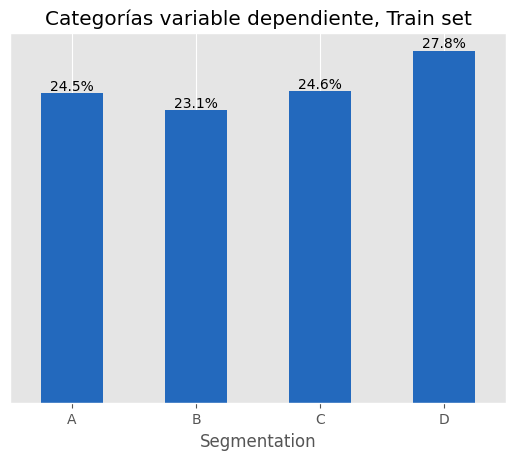

In [46]:
ax = train.Segmentation.value_counts(normalize = True).sort_index().plot( kind = 'bar', colormap = 'vlag')
ax.get_yaxis().set_visible(False)
labels = (train.Segmentation.value_counts(normalize = True).sort_index()*100).round(1).astype('str') + '%' ## ETIQUETA DE LAS BARRAS QUE SE MUESTRE EN %
ax.tick_params(axis = 'x', rotation = 0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax.set_title("Categorías variable dependiente, Train set")
for container in ax.containers:
    ax.bar_label(container, labels = labels)
plt.show()

### **Descripción variable numéricas vs variable dependiente**
En la siguiente figura se encuentra la distribución de las variables numéricas independientes en terminos de la variable "Segementation" que es la variable dependiente. De izquierda a derecha se encuentral la Edad, en la parte central la experencia laboral y en la zona derecha el tamaño de la familia.

* **Segmentación vs Edad:**

 En este gráfico el grupo D, tiene en promedio una edad menor que el resto de grupos, 32 años. Sin embargo, es el grupo con mayor asimetría en la distribucción de la variable "Age". Los 3 grupos restantes tienen una edad promedio muy cercana a los 50 años.

* **Segmentación vs Experiencia laboral**

En cuanto la distribución de la variable "Work experience", para todas las categorías de Segmentation se encuentra que el promedio esta entre los 2 y 3 años. Sin embargo, es el grupo D el de mayor promedio y también es posible identificar que los registros en este grupo son los que más experiencia tienen puesto que un 75% de los individuos tienen una experiencia laboral de 5 años o menos, y los grupos B y C son los que menos experiencia tienen ya que el  75% de los individuos tienen una experiencia de 3 años o menos.


* **Segmentation vs Family Size**

El tamaño del núcleo familiar tiene una distribución similar para los segmentos B, C y D, donde el 75% de los individuos de cada uno de estos grupos tiene un núcleo familiar conformado por 4 o menos personas. Por otra parte, el núcleo familiar del Segmento A es el más reducido donde el 75% de los individuos tienen un núcleo familiar de 3 o menos personas.

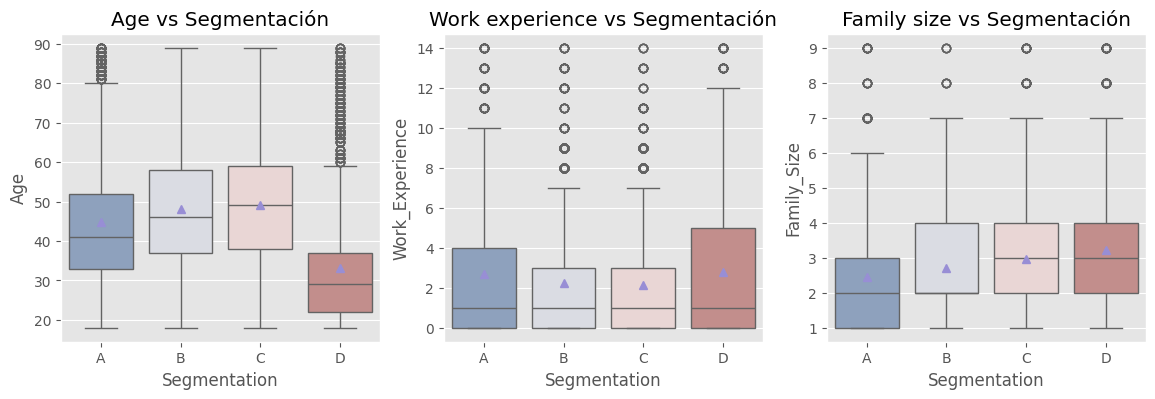

In [21]:
fig, (ax1 ,ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
sns.boxplot(data = train, x = 'Segmentation', y = 'Age',order = train.Segmentation.sort_values().unique(), ax = ax1, showmeans = True, palette = 'vlag').set(title='Age vs Segmentación')
sns.boxplot(data = train, x = 'Segmentation', y = 'Work_Experience', order = train.Segmentation.sort_values().unique(), ax = ax2, showmeans = True,palette="vlag").set(title='Work experience vs Segmentación')
sns.boxplot(data = train, x = 'Segmentation', y = 'Family_Size', order = train.Segmentation.sort_values().unique(), ax = ax3, showmeans = True, palette="vlag").set(title='Family size vs Segmentación')
plt.show()

### **Descripción variable categóricas vs variable dependiente**
* **Género vs Segmentación**

   Con respecto a la distribución del género por Segmentación, la participación en todos los grupos de ambos géneros es similar a excepción del grupo D, donde la participación de los hombres es casi del 60%.

* **Ever_Married vs Segmentación**
  
  La variable categórica que toma en cuenta si el individuo ha estado casado alguna vez presenta la siguiente distribución: en los grupos A, B y C la mayoría de personas han estado casados, teniendo una mayor participación en los grupos B y C alcanzando casi el 80%. El grupo D por el contrario más del 70% de los individuos no han estado casados, este grupo como se vió en anteriores gráficas es el grupo con menor promedio de edad.
  
* **Graduated vs Segmentation**

    La variable binaria que captura si el individuo se graduó presenta el siguiente comportamiento: En los grupos A, B y C más del 60% son graduados, caso contrario en el grupo D donde poco más del 60% de los individuos no son graduados.

* **Spending_Score vs Segmentation**
    La variable categórica que captura si el puntaje de consumo es bajo, medio o alto presenta la siguiente distribución: Los grupos A, B y D predominan las personas que tienen un consumo bajo, siendo en el grupo D casi la totalidad de personas que tienen un consumo bajo, por su parte en el grupo C predomina el consumo promedio con un poco más del 40%.

* **Profession vs Segmentation**
  
  Con respecto a la profesión del cliente:
    - El grupo A la mayor participación la tienen los artistas con casi el 30% de los individuos, seguido de los profesionales del entretenimiento.
    - El grupo B la mayor participación la tienen los artistas con más del 40% de los individuos, seguido por los profesionales del entretenimiento.
    - El grupo C la mayor participación la tienen los artistas con más del 50% de los individuos, seguido por los ejecutivos.
    - El grupo D la mayor participación la tienen los profesionales de la salud con más del 40%, seguido por los doctores y profesionales del entretenamiento.
     
* **Var_1 vs Segmentation**

  Con respecto a una categoría anónima que se le asigna a cada cliente la categoría 6 tiene la mayor participación en todos los segmentos con más del 60% de todos los individuos para los grupos A, B y C, y poco más del 50% en el grupo D.

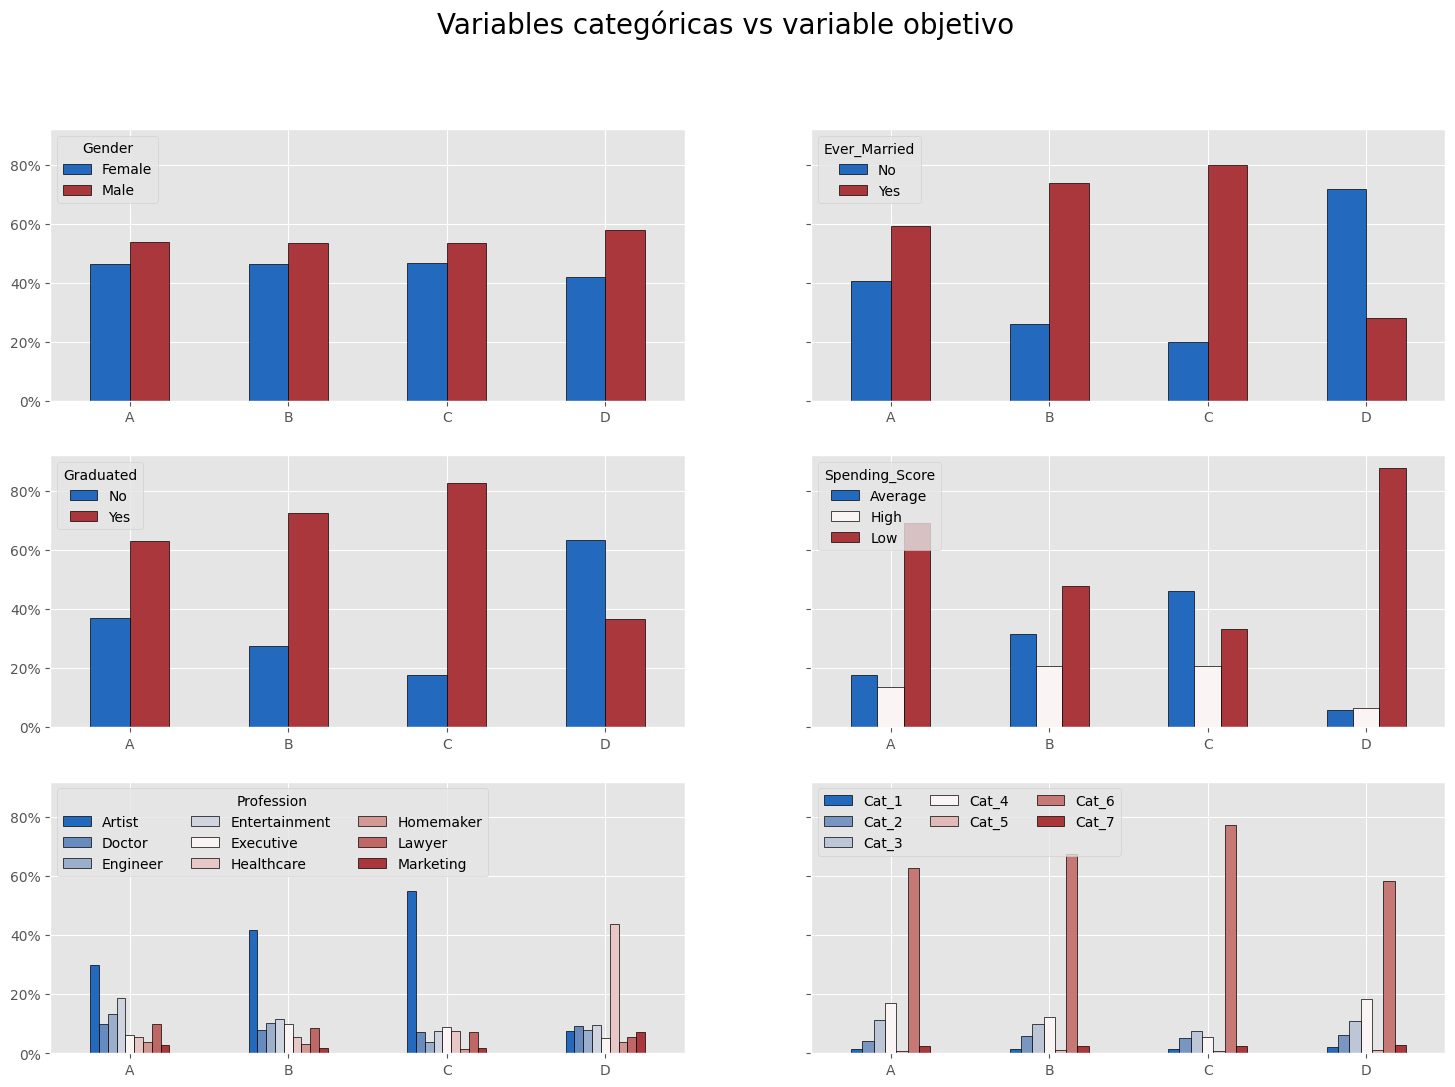

In [23]:
fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6)) = plt.subplots(3,2, figsize = (18,12), sharey = True)
pd.crosstab(train.Segmentation,train.Gender,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black',colormap= 'vlag')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left', title = 'Gender')
ax1.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Ever_Married,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black', colormap= 'vlag')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
ax2.legend(loc = 'upper left',  title = 'Ever_Married')
ax2.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Graduated,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax3, edgecolor = 'black',colormap= 'vlag')
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax3.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax3.legend(loc = 'upper left', title = 'Graduated')
ax3.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Spending_Score,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax4, edgecolor = 'black',colormap= 'vlag')
ax4.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax4.tick_params(axis='x', rotation = 0) 
ax4.legend(loc = 'upper left', title = 'Spending_Score')
ax4.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Profession,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax5, edgecolor = 'black',colormap= 'vlag')
ax5.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax5.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax5.legend(loc = 'upper left', ncols = 3, title = 'Profession')
ax5.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Var_1,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax6, edgecolor = 'black',colormap= 'vlag')
ax6.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax6.tick_params(axis='x', rotation=0) 
ax6.legend(loc = 'upper left', ncols = 3)
ax6.set_xlabel(None)
fig.suptitle('Variables categóricas vs variable objetivo', fontsize = 20)
plt.show()

In [24]:
def calcular_coeficiente_contingencia(df: pd.DataFrame, cols: list, target_col: str) -> pd.DataFrame:
    resultados = []
    for col in cols:
        tabla_contingencia = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
        n = tabla_contingencia.values.sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(len(tabla_contingencia.index) - 1, len(tabla_contingencia.columns) - 1)))
        resultados.append([col, coef_contingencia])
    df_resultado = pd.DataFrame(resultados, columns=['Variable', 'Coeficiente de Contingencia'])
    df_resultado.sort_values(by='Coeficiente de Contingencia', ascending=False, inplace=True)
    df_resultado.reset_index(drop=True, inplace=True)
    return df_resultado.round(4)

**Interpretación asociación entre variables categóricas independientes y variable objetivo**
 - Todas las variables tienen un coeficiente menor a 0.6, por lo que ninguna presenta una asociación relativamente intensa con la variable objetivo. Sin embargo, la variable Ever_Married es la que mayor coeficiente de asociación tiene.


In [25]:
calcular_coeficiente_contingencia(train,categ_idx, 'Segmentation')

,Variable,Coeficiente de Contingencia
0,Ever_Married,0.4181
1,Graduated,0.3619
2,Profession,0.3295
3,Spending_Score,0.3098
4,Var_1,0.1012
5,Gender,0.0398


## Entrenamiento modelos de clasificación

In [26]:
## Definir protocolos de evaluación, se utilizan las métricas accuracy, kappa, precision y recall.
def ClfScores(model, x_train, y_train, x_test, y_test, labels = train[target_idx]['Segmentation'].unique()):
    '''
    model : must be a previously fitted estimator
    '''
    yTest_pred = model.predict(x_test)
    yTrain_pred = model.predict(x_train)
    acc_test = accuracy_score(y_test, yTest_pred)
    acc_train = accuracy_score(y_train, yTrain_pred)
    ck_train = cohen_kappa_score(y_train, yTrain_pred)
    ck_test = cohen_kappa_score(y_test, yTest_pred)
    precision_train = precision_score(y_train, yTrain_pred, average = None)
    precision_test = precision_score(y_test, yTest_pred, average = None)
    rec_train = recall_score(y_train, yTrain_pred, average = None)
    rec_test = recall_score(y_test, yTest_pred, average = None)
    metrics = {
                'Accuracy test' : acc_test,
                'Accuracy train' : acc_train,
                'Cohen Kappa train' :  ck_train,
                'Cohen Kappa test' :  ck_test,
                'Precision train' : precision_train,
                'Precision test' : precision_test,
                'Recall train' :  rec_train,
                'Recall test'  :  rec_test
    }
    for i in metrics.keys():
        print(i,' : ', metrics.get(i))
    disp = ConfusionMatrixDisplay.from_estimator( #Adaptado de : https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
            model,
            x_test,
            y_test,
            display_labels = labels,
            cmap=plt.cm.Purples,
        )
    disp.ax_.set_title('Confusion matrix')
    plt.show()
    return None

* Se hace el HoldOut de los datos de train, utilizando el 80% para entrenamiento y el 20% restante para validación

In [27]:
## HoldOut -> Train (80%), Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(train[num_idx + categ_idx], train[target_idx], test_size = 0.2, random_state = 123)

target_transf = LabelEncoder()  ## Es necesario etiquetar la variable objetivo, algunos algoritmos lo requieren (XGBClassifier)
y_train = target_transf.fit_transform(y_train)
y_val = target_transf.transform(y_val)

**Entrenamiento de los modelos**

Se utiliza el DummyClassifier como modelo base con el cual se va a comparar el resto de modelos entrenados.

Accuracy test  :  0.2686472819216182
Accuracy train  :  0.2803856488067014
Cohen Kappa train  :  0.0
Cohen Kappa test  :  0.0
Precision train  :  [0.         0.         0.         0.28038565]
Precision test  :  [0.         0.         0.         0.26864728]
Recall train  :  [0. 0. 0. 1.]
Recall test  :  [0. 0. 0. 1.]


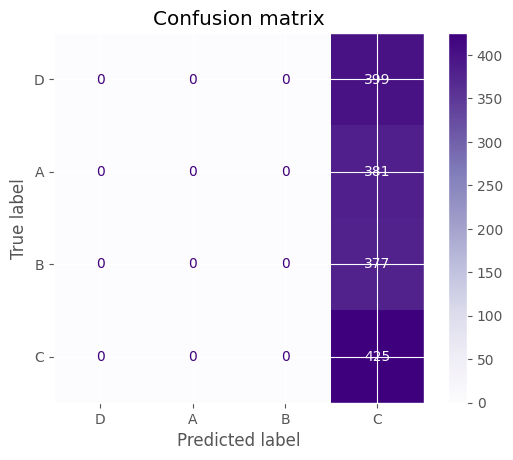

In [28]:
## Baseline
dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)
ClfScores(dummy_clf,X_train, y_train, X_val, y_val)

* **Grid parameters**

Se establecen una grilla que contiene una lista de posibles valores de los hiperparámetros de los modelos a entrenar.

In [29]:
## Grid parameters for each of the models
rf_grid_params = { 'model__max_depth': [4,10,20,30],
                   'model__max_leaf_nodes': [4,6,8,14,22,30],
                   'model__min_samples_leaf': [5,10,20],
                   'model__min_samples_split': [2, 5, 10,20],
                   'model__n_estimators': [100,200,300]}

nb_grid_params = {'model__var_smoothing': np.logspace(0,-9, num = 100)}

kn_grid_params = {'model__n_neighbors' : np.arange(1,70)}

xgb_grid_params = {'model__learning_rate': [0.01,0.03,0.1,],
                   'model__subsample'    : [1, 0.5, 0.2],
                   'model__n_estimators' : [500,1000,1500],
                   'model__reg_alpha': [0.01,0.05,0.1,1,10],
                   'model__reg_lambda': [0.01,0.05,0.1,1,10],
                   'model__max_depth'    : [None,5,7,12,15,20] }

* En la búsqueda de los hiperparámteros óptimos del modelo RandomForest, se le pasa al algoritmo una lista de valores para escoger los mejores hiperparámetros de:
    - La profundidad del arbol (ya que si no se determina un umbral, el arbol crece hasta que todas las hojas sean puras o el número de muestras sea menor al min_sample_split), lo que probablemente lleva a un modelo con poca capacidad de generalización.
    - Número de nodos hoja.
    - Mínimo número de muestras para ser un nodo terminal.
    - Mínimo número de muestras para dividir el nodo
    - Número de árboles a entrenar.

In [ ]:
## RandomForest // NO CORRER DEMORA ALREDEDOR DE 10 MIN ENTRENANDO - ES MEJOR CARGAR EL JOBLIB YA ENTRENADO
# rf_gs = GridSearchCV(clone(pl_dict.get('RandomForest')), rf_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
# rf_gs.fit(X_train, y_train)
# rf_model = clone(pl_dict.get('RandomForest')).set_params(**rf_gs.best_params_) # Se entrena de nuevo el modelo ya con los hiperparámetros óptimos obtenidos con GridSearchCV
# rf_model.fit(X_train, y_train)
# ClfScores(rf_model,X_train, y_train, X_val, y_val)
## Guardar el modelo entrenado
# joblib.dump(rf_model, 'RF_pl_04122023.joblib')

Accuracy test  :  0.5214917825537294
Accuracy train  :  0.5476529160739687
Cohen Kappa train  :  0.39321485638044973
Cohen Kappa test  :  0.3598359998503259
Precision train  :  [0.46186699 0.45743473 0.56082239 0.64348249]
Precision test  :  [0.4589372  0.42424242 0.53103448 0.59813084]
Recall train  :  [0.49251789 0.27850726 0.62587635 0.74577227]
Recall test  :  [0.47619048 0.22047244 0.6127321  0.75294118]


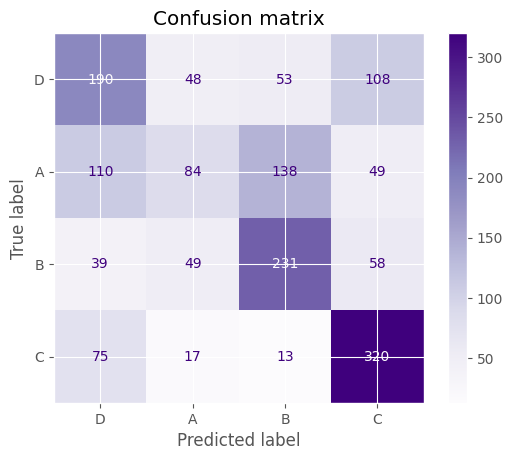

In [30]:
## Cargar el modelo entrenado
rf_saved = joblib.load('RF_pl_04122023.joblib')
ClfScores(rf_saved,X_train, y_train, X_val, y_val)

* **Regresión Logística**

No tiene hiperparámetros que optimizar.

Accuracy test  :  0.5139064475347661
Accuracy train  :  0.5158843053579896
Cohen Kappa train  :  0.3510956530147953
Cohen Kappa test  :  0.3503694147248987
Precision train  :  [0.41864407 0.40755208 0.51560021 0.65068493]
Precision test  :  [0.43678161 0.40104167 0.50425532 0.6371134 ]
Recall train  :  [0.482108   0.21630961 0.62141491 0.69616685]
Recall test  :  [0.47619048 0.20209974 0.62864721 0.72705882]


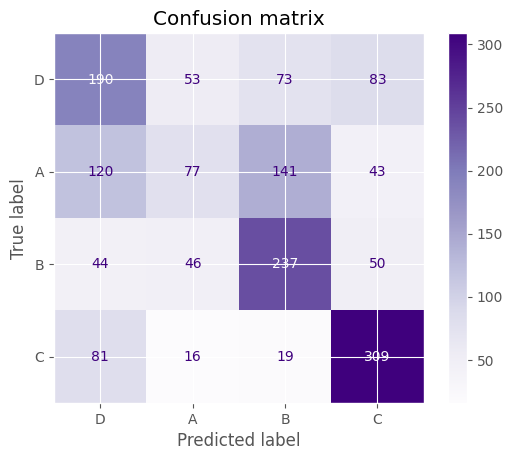

In [31]:
## LogisticRegression
lr_model = clone(pl_dict.get('LogisticRegression'))
lr_model.fit(X_train, y_train)
ClfScores(lr_model,X_train, y_train, X_val, y_val)

* **NaiveBayes**

El algoritmo de NaiveBayes sólo tiene un hiperparámetro para buscar, var_smoothing que equivale a el ${\epsilon}$ > 0 para evitar que alguna de las probabilidades sea cero.

Accuracy test  :  0.4949431099873578
Accuracy train  :  0.49865655128813025
Cohen Kappa train  :  0.32722667696659846
Cohen Kappa test  :  0.32554627839174954
Precision train  :  [0.44932432 0.38042131 0.46065013 0.62012012]
Precision test  :  [0.48122867 0.39215686 0.45053004 0.59152216]
Recall train  :  [0.34612882 0.2121631  0.68642447 0.69842165]
Recall test  :  [0.35338346 0.20997375 0.67639257 0.72235294]


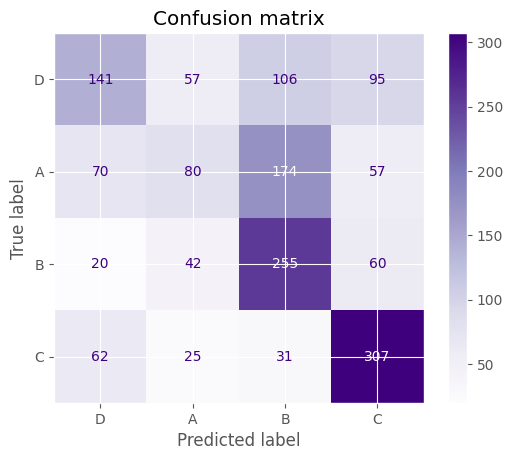

In [32]:
## NaiveBayes
nb_gs = GridSearchCV(clone(pl_dict.get('NaiveBayes')), nb_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
nb_gs.fit(X_train, y_train)
nb_model = clone(pl_dict.get('NaiveBayes')).set_params(**nb_gs.best_params_)
nb_model.fit(X_train, y_train)
ClfScores(nb_model,X_train, y_train, X_val, y_val)

* **KNeighborsClassifier**

El algoritmo de KNeighborsClassifier sólo tiene un hiperparámetro para buscar, el número de vecinos, donde un número de vecinos cercano a uno puede llevar a un modelo con overfitting.

Accuracy test  :  0.511378002528445
Accuracy train  :  0.531847637110795
Cohen Kappa train  :  0.37247769459250724
Cohen Kappa test  :  0.3471869301366177
Precision train  :  [0.47066849 0.41551541 0.52165053 0.64384262]
Precision test  :  [0.46233766 0.40434783 0.50421941 0.60649087]
Recall train  :  [0.44892648 0.27021424 0.652645   0.7102593 ]
Recall test  :  [0.44611529 0.24409449 0.63395225 0.70352941]


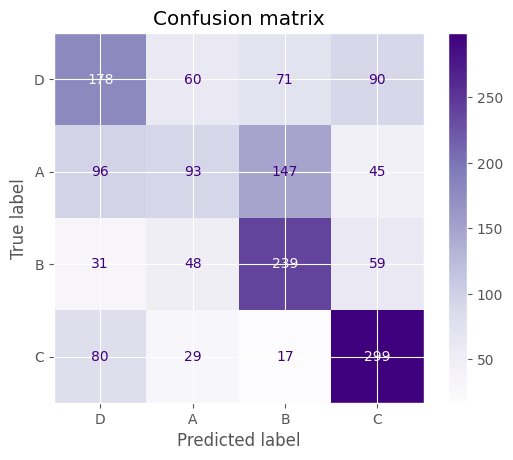

In [33]:
## KNeighborsClassifier
kn_gs = GridSearchCV(clone(pl_dict.get('KNeighborsClassifier')), kn_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
kn_gs.fit(X_train, y_train)
kn_model = clone(pl_dict.get('KNeighborsClassifier')).set_params(**kn_gs.best_params_)
kn_model.fit(X_train, y_train)
ClfScores(kn_model,X_train, y_train, X_val, y_val)

* **XGBoostClassifier**
* Por su parte XGBoost, es el modelo al que más hiperparámetros se le debe probar, entre los cuales se encuentran:
    - learning_rate : parámetro que controla el overfitting.
    - subsample : porción del número de registros de entrenamiento sobre la cual se entrenan los árboles, por defecto se usan todas los registros (subsample = 1).
    - n_estimators : número de árboles a entrenar.
    - reg_alpha : regularización L1.
    - reg_lambda : regularización L2.
    - max_depth : profundidad máxima de los árboles.

In [ ]:
## XGBClassifier // NO CORRER DEMORA ALREDEDOR DE 30 MIN ENTRENANDO - ES MEJOR CARGAR EL JOBLIB YA ENTRENADO
# xgb_gs = GridSearchCV(clone(pl_dict.get('XGBClassifier')), xgb_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
# xgb_gs.fit(X_train, y_train)
# xgb_model = clone(pl_dict.get('XGBClassifier')).set_params(**xgb_gs.best_params_)
# xgb_model.fit(X_train, y_train)
# ClfScores(xgb_model,X_train, y_train, X_val, y_val)
## Guardar el modelo entrenado
# joblib.dump(xgb_model, 'XGB_pl_04122023.joblib')

Accuracy test  :  0.5398230088495575
Accuracy train  :  0.605184131499921
Cohen Kappa train  :  0.47077019040604995
Cohen Kappa test  :  0.3845377738113688
Precision train  :  [0.53260207 0.54536772 0.63184393 0.67317073]
Precision test  :  [0.48284314 0.4280303  0.56298201 0.62380038]
Recall train  :  [0.56864021 0.39460954 0.63989802 0.77790304]
Recall test  :  [0.49373434 0.29658793 0.58090186 0.76470588]


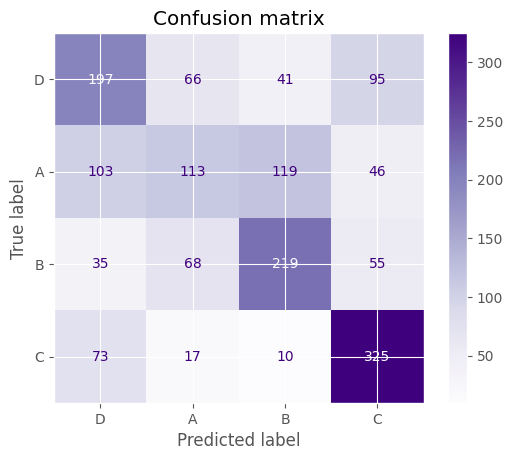

In [35]:
xgb_saved = joblib.load('XGB_pl_04122023.joblib')
ClfScores(xgb_saved,X_train, y_train,  X_val, y_val)

* Se carga el conjunto de prueba "Test.csv" con el cual se va a validar el desempeño de los modelos entrenados.

In [36]:
df_test = pd.read_csv("Test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
 10  Segmentation     2627 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 225.9+ KB


In [37]:
## Se verifica si hay datos duplicados
df_test.loc[df_test.duplicated()] # No hay duplicados

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


In [38]:
## Se elimina la variable ID, no es relevante para el análisis
df_test.drop('ID', axis = 1, inplace = True)

# Separar el data set de test con la función
num_idx_test, categ_idx_test, target_idx_test = SepararNumCate(df_test)

# Usar el pipeline de imputación (imput_str2) previamente entrenado
test_clean = pd.DataFrame(imput_str2.transform(df_test), columns = num_idx_test + categ_idx_test + target_idx_test)

test_clean_ = test_clean.copy().astype(train1.dtypes.to_dict()) ## Se le asignan el tipo de variables de uno de los datasets ya que con la imputación todas las variables quedan como tipo object.

In [39]:
## Dividir el conjunto de prueba
X_test = test_clean_[num_idx_test + categ_idx_test]
y_test = test_clean_[target_idx_test]
y_test = target_transf.transform(y_test) ## Encoder previamente entrenado en los datos de train

* Se crea un DataFrame con el resultado de las métricas de los 5 modelos propuestos (más el baseline) en los conjuntos de entrenamiento, validación y prueba. Se escoge el modelo que mejor desempeño tenga en las métricas del conjunto de datos prueba.

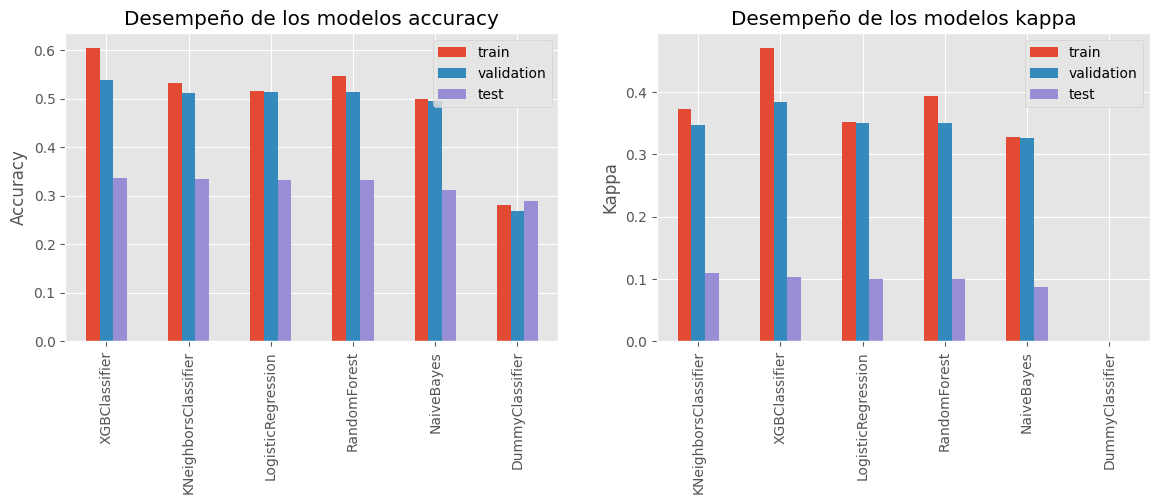

In [42]:
kappa_resulados = {
    'DummyClassifier':
            {'train' : cohen_kappa_score(y_train, dummy_clf.predict(X_train)),
             'validation' : cohen_kappa_score(y_val, dummy_clf.predict(X_val)), 
             'test' : cohen_kappa_score(y_test, dummy_clf.predict(X_test)),},
    'LogisticRegression':
           {'train' : cohen_kappa_score(y_train, lr_model.predict(X_train)),
             'validation' : cohen_kappa_score(y_val, lr_model.predict(X_val)), 
             'test' : cohen_kappa_score(y_test, lr_model.predict(X_test)),},
    'RandomForest':
           {'train' : cohen_kappa_score(y_train, rf_saved.predict(X_train)),
             'validation' : cohen_kappa_score(y_val, lr_model.predict(X_val)), 
             'test' : cohen_kappa_score(y_test, lr_model.predict(X_test)),},
    'KNeighborsClassifier':
           {'train' : cohen_kappa_score(y_train, kn_model.predict(X_train)),
             'validation' : cohen_kappa_score(y_val, kn_model.predict(X_val)), 
             'test' : cohen_kappa_score(y_test, kn_model.predict(X_test)),},
    'NaiveBayes':
           {'train' : cohen_kappa_score(y_train, nb_model.predict(X_train)),
             'validation' : cohen_kappa_score(y_val, nb_model.predict(X_val)), 
             'test' : cohen_kappa_score(y_test, nb_model.predict(X_test)),},
    'XGBClassifier':
            {'train' : cohen_kappa_score(y_train, xgb_saved.predict(X_train)),
             'validation' : cohen_kappa_score(y_val, xgb_saved.predict(X_val)), 
             'test' : cohen_kappa_score(y_test, xgb_saved.predict(X_test)),},
}


accuracy_resultados = {
    'DummyClassifier':
            {'train' : accuracy_score(y_train, dummy_clf.predict(X_train)),
             'validation' : accuracy_score(y_val, dummy_clf.predict(X_val)), 
             'test' : accuracy_score(y_test, dummy_clf.predict(X_test)),},
    'LogisticRegression':
           {'train' : accuracy_score(y_train, lr_model.predict(X_train)),
             'validation' : accuracy_score(y_val, lr_model.predict(X_val)), 
             'test' : accuracy_score(y_test, lr_model.predict(X_test)),},
    'RandomForest':
           {'train' : accuracy_score(y_train, rf_saved.predict(X_train)),
             'validation' : accuracy_score(y_val, lr_model.predict(X_val)), 
             'test' : accuracy_score(y_test, lr_model.predict(X_test)),},
    'KNeighborsClassifier':
           {'train' : accuracy_score(y_train, kn_model.predict(X_train)),
             'validation' : accuracy_score(y_val, kn_model.predict(X_val)), 
             'test' : accuracy_score(y_test, kn_model.predict(X_test)),},
    'NaiveBayes':
           {'train' : accuracy_score(y_train, nb_model.predict(X_train)),
             'validation' : accuracy_score(y_val, nb_model.predict(X_val)), 
             'test' : accuracy_score(y_test, nb_model.predict(X_test)),},
    'XGBClassifier':
            {'train' : accuracy_score(y_train, xgb_saved.predict(X_train)),
             'validation' : accuracy_score(y_val, xgb_saved.predict(X_val)), 
             'test' : accuracy_score(y_test, xgb_saved.predict(X_test)),},
}

accuracy_models = pd.DataFrame(accuracy_resultados)
kappa_models = pd.DataFrame(kappa_resulados)


fig, (ax0, ax1) = plt.subplots(1,2, figsize = (14,4))
accuracy_models.T.sort_values(by = ['test','validation'], ascending = False).plot(kind = 'bar', ax = ax0)
kappa_models.T.sort_values(by = ['test','validation'], ascending = False).plot(kind = 'bar', ax = ax1)
ax0.set_title('Desempeño de los modelos accuracy')
ax0.set_ylabel('Accuracy')
ax1.set_title('Desempeño de los modelos kappa')
ax1.set_ylabel('Kappa')
plt.show()

- **XGBoostClassifier** fue el modelo con mejor desempeño en las métricas evaluadas en los conjuntos train, validation y test (a excepción del kappa, donde KNeighbors tuvo un desempeño un poco superior en esta métrica)

- Es relevante señalar la importante disminución de las métricas de evaluación entre los conjuntos de validación y de prueba. Este comportamiento posiblemente sea porque el conjunto de prueba no tiene un comportamiento similar al del conjunto de entrenamiento en relación con el balanceo de la variable objetivo. En la gráfica siguiente se muestra la distribución porcentual de las clases de la variable objetivo del conjunto de prueba y se observa que no tiene una participación similar de las clases observada en el conjunto de entrenamiento (las 4 clases tenían una participación de alrededor del 25% cada una). Por el contrario en el dataset de prueba la clase A tiene una participación del 32%, mientras que la clase C tiene una participación del 18% (diferencia de 14 puntos porcentuales entre las clases A y C).

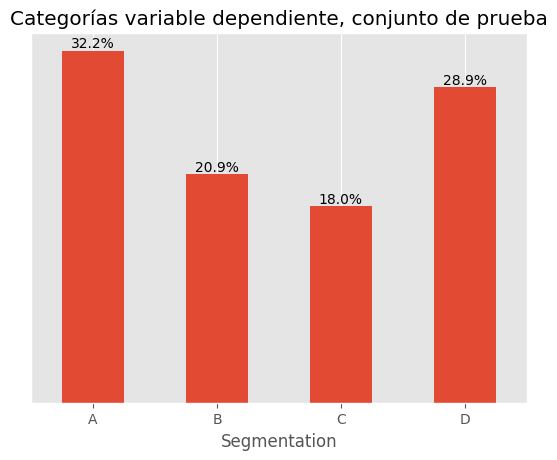

In [47]:
ax = df_test.Segmentation.value_counts(normalize = True).sort_index().plot( kind = 'bar')
ax.get_yaxis().set_visible(False)
labels = (df_test.Segmentation.value_counts(normalize = True).sort_index()*100).round(1).astype('str') + '%' ## ETIQUETA DE LAS BARRAS QUE SE MUESTRE EN %
ax.tick_params(axis = 'x', rotation = 0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax.set_title("Categorías variable dependiente, conjunto de prueba")
for container in ax.containers:
    ax.bar_label(container, labels = labels)
plt.show()

## Reducción de dimensionalidad


### Análisis de componentes principales

In [48]:
## Realizamos una copia del dataset derivado de la limpieza de datos
train_pca = train.copy()

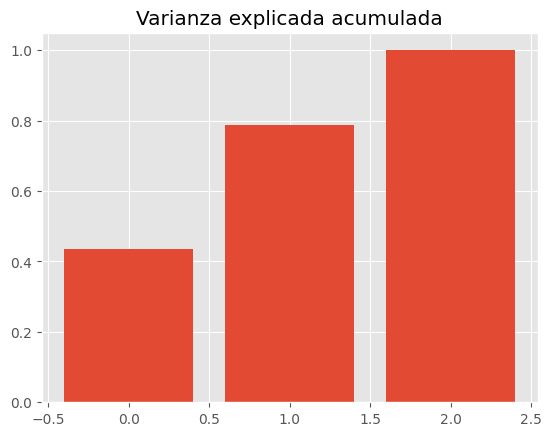

In [50]:
## Se estandarizan las variables y se ajusta el PCA (Sólo con las variables numéricas)
num_std = StandardScaler().fit_transform(train[num_idx])
pca_num = PCA()
pca_num.fit(num_std)

plt.bar(range(len(np.cumsum(pca_num.explained_variance_ratio_))),np.cumsum(pca_num.explained_variance_ratio_))
plt.title('Varianza explicada acumulada')
plt.show()

* La proporción de la varianza explicada con 2 componentes (78.6%) es muy cercana al 80%, por lo que se utilizarán los 2 primeros componentes principales.

In [51]:
## Fragmento de código adaptado de: https://www.jcchouinard.com/python-pca-biplots-machine-learning/

pca_features = pca_num.transform(train[num_idx])
 
# Principal components correlation coefficients
loadings = pca_num.components_
 
# Number of features before PCA
n_features = pca_num.n_features_in_
 
# Feature names before PCA
feature_names = num_idx
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2,PC3
feature_names,,,
Age,-0.732851,-0.079149,0.675770
Work_Experience,0.310701,0.844675,0.435877
Family_Size,0.605305,-0.529395,0.594430


**Interpretación de los 2 primeros componentes principales:**

* PC1 -> Este componente representa principalmente la edad (en el sentido negativo) y el tamaño de la familia (en el sentido positivo), y en menor magnitud la experiencia laboral (en sentido positivo).

* PC2 -> Este componente representa en mayor medida la experiencia laboral (en el sentido positivo), seguido del tamaño de la familia (en el sentido negativo). Mientras que la edad tiene una baja contribución (en su sentido negativo) a este componente.


**Interpretación gráfico biplot:**


De acuerdo con las contribuciones que tiene cada una de las variables a los componentes, es la edad la variable que mejor queda representada en el PC1, contrario a la experiencia laboral que contribuye en mayor medida al PC2 y en menor medida al PC1. Para la variable tamaño de la familia, el aporte es más equitativo (PC1 en sentido positivo, PC2 en sentido negativo).


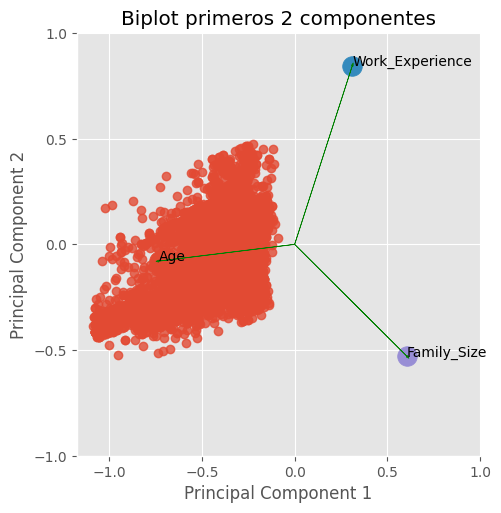

In [67]:
xs = loadings[0]
ys = loadings[1]
 
# Create DataFrame from PCA
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2','PC3'])

 
# Scale PCS into a DataFrame
pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2','PC3']]
scaler = 1 / (scaler_df.max() - scaler_df.min())
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]
 
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df_scaled, 
    fit_reg=False, 
    )
 
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='green', 
        head_width=0.01
        )
    plt.text(xs[i], ys[i], varnames)
 
xticks = np.linspace(-1, 1, num=5)
yticks = np.linspace(-1,1, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
 
plt.title('Biplot primeros 2 componentes')
plt.show()

## Caracterización de los clientes por segmento

* Ya con el dataset transformado con los loadings del PCA (sólo con las variables numéricas) se procede a realizar una nueva segmentación de clientes con los modelos de aprendizaje no supervisado.

In [68]:
dataPCAKM = pca_df.iloc[:,:2].copy()

In [72]:
data_scaled = StandardScaler().fit(dataPCAKM)
data_pca_scaled = data_scaled.transform(dataPCAKM)

In [78]:
def encontrar_numero_clusters(X):
    # Crea una lista vacía para almacenar la inercia
    inertia = []

    # Prueba diferentes números de clusters de 1 a N
    for i in range(1, 6):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Calcula la inercia acumulada
    inertia_cumulative = np.cumsum(inertia)

    # Calcula el porcentaje de la inercia acumulada
    total_inertia = inertia_cumulative[-1]
    inertia_percentage = (inertia_cumulative / total_inertia) * 100

    # Encuentra el número de clusters que recoja el 90% de la inercia
    n_clusters_95_percent = np.argmax(inertia_percentage >= 95) + 1

    # Visualiza la curva de la inercia acumulada
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 6), inertia_percentage, marker='o', linestyle='--')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia Acumulada (%)')
    plt.title('Curva de Codo')
    plt.grid(True)
    plt.show()

    print(f"Número de clusters que recoja el 95% de la inercia: {n_clusters_95_percent}")

    return None

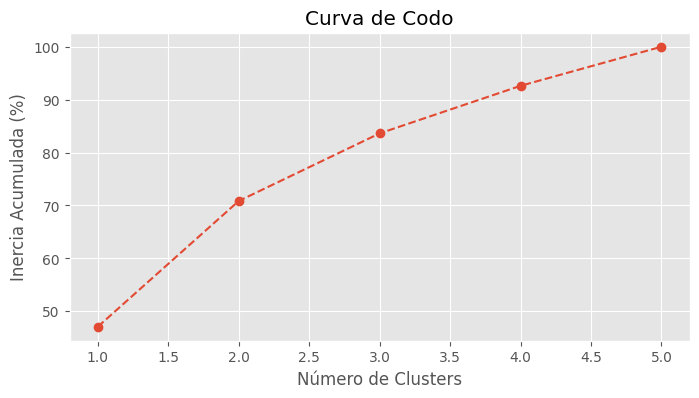

Número de clusters que recoja el 95% de la inercia: 5


In [79]:
encontrar_numero_clusters(data_pca_scaled)

* En la anterior gráfica se observa que el número de clústers que recoje el 95% de la inercia total es 5, no obstante con 4 se recoje más del 90% de esta, se probarán con otro método para elegir el K óptimo.

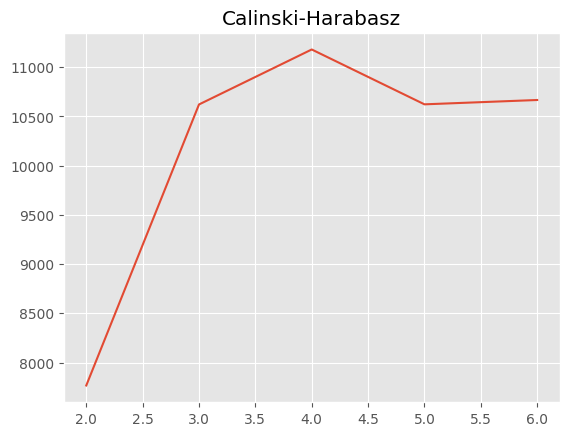

In [80]:
CHs = []
for i in range(2,7):
    km = KMeans(n_clusters=i, random_state=0, n_init = 30)
    km.fit(data_pca_scaled)
    CH = calinski_harabasz_score(data_pca_scaled, km.labels_) 
    CHs.append(CH)
CHs
plt.title('Calinski-Harabasz')
plt.plot(range(2,7), CHs)
plt.show()

* De acuerdo con el *Calinski-Harabasz*, el número óptimo de clústers es **4**. 

Se entrena el modelo de KMeans con 4 clústers.

In [91]:
Kmeans_final = KMeans(random_state=0,n_clusters = 4)
Kmeans_final.fit(data_scaled.transform(dataPCAKM))
clust_lab = Kmeans_final.labels_

data_frame_scaled = pd.DataFrame(data_pca_scaled, columns = ['PC1','PC2'])
data_frame_scaled['clust_labels'] = clust_lab

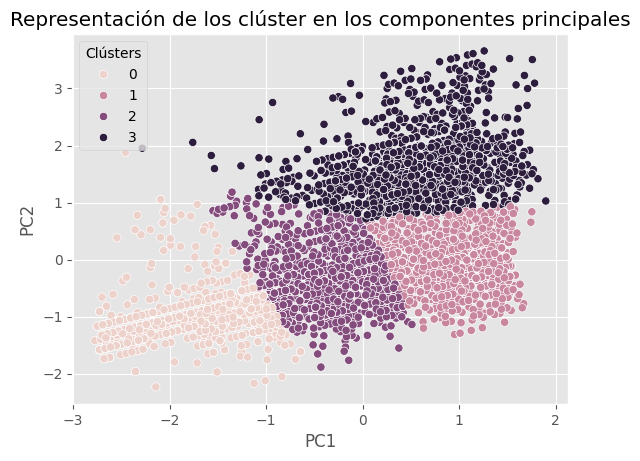

In [92]:
ax = sns.scatterplot(data = data_frame_scaled, x = 'PC1', y = 'PC2', hue = 'clust_labels')
ax.legend(title = 'Clústers')
ax.set_title('Representación de los clúster en los componentes principales')
plt.show()

* Le añadimos la nueva etiqueta a las observaciones, la cual es el número de clúster en el cual quedó cada observación.

In [93]:
trainClust = train_pca.merge(data_frame_scaled, left_index = True, right_index = True)

* Se encuentra que la mayoría de observaciones se encuentran en los clústers 1 y 2.

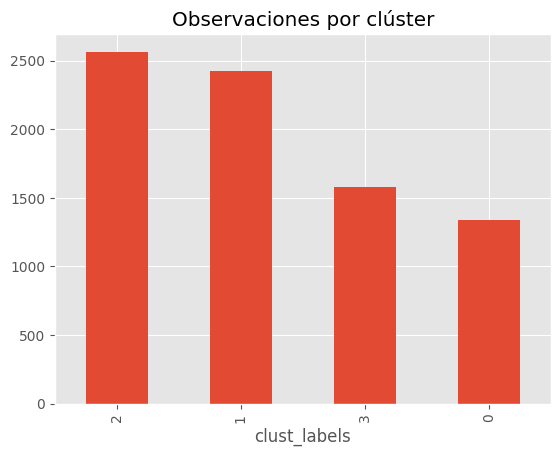

In [94]:
trainClust.clust_labels.value_counts().plot(kind = 'bar')
plt.title('Observaciones por clúster')
plt.show()

In [98]:
trainClust.groupby('clust_labels')[['Age','Work_Experience','Family_Size']].mean().reset_index()

,clust_labels,Age,Work_Experience,Family_Size
0,0,71.548098,0.806115,2.258762
1,1,28.328383,1.070957,3.440182
2,2,47.758769,1.139127,2.802027
3,3,35.904943,8.302281,2.544360


**Caracterización de los clientes por nuevos segmentos:**

-  Clúster 0 : Individuos de una edad avanzada (promedio alrededor 72 años), poca experiencia laboral (promedio menos de un año) y un tamaño familiar promedio entre 2 y 3 integrantes.
-  Clúster 1 : Individuos jóvenes (promedio 28 años), poca experiencia laboral (promedio un año) y un tamaño familiar promedio entre 3 y 4 integrantes.
-  Clúster 2 : Individuos de edad adulta (promedio 48 años), con poca experiencia laboral (promedio un año) y tamaño familiar promedio entre 2 y 3 integrantes.
-  Clúster 3 : Individuos de edad adulta (promedio 36 años), mucha experiencia laboral (promedio 8 años) y tamaño familiar promedio entre 2 y 3 integrantes.


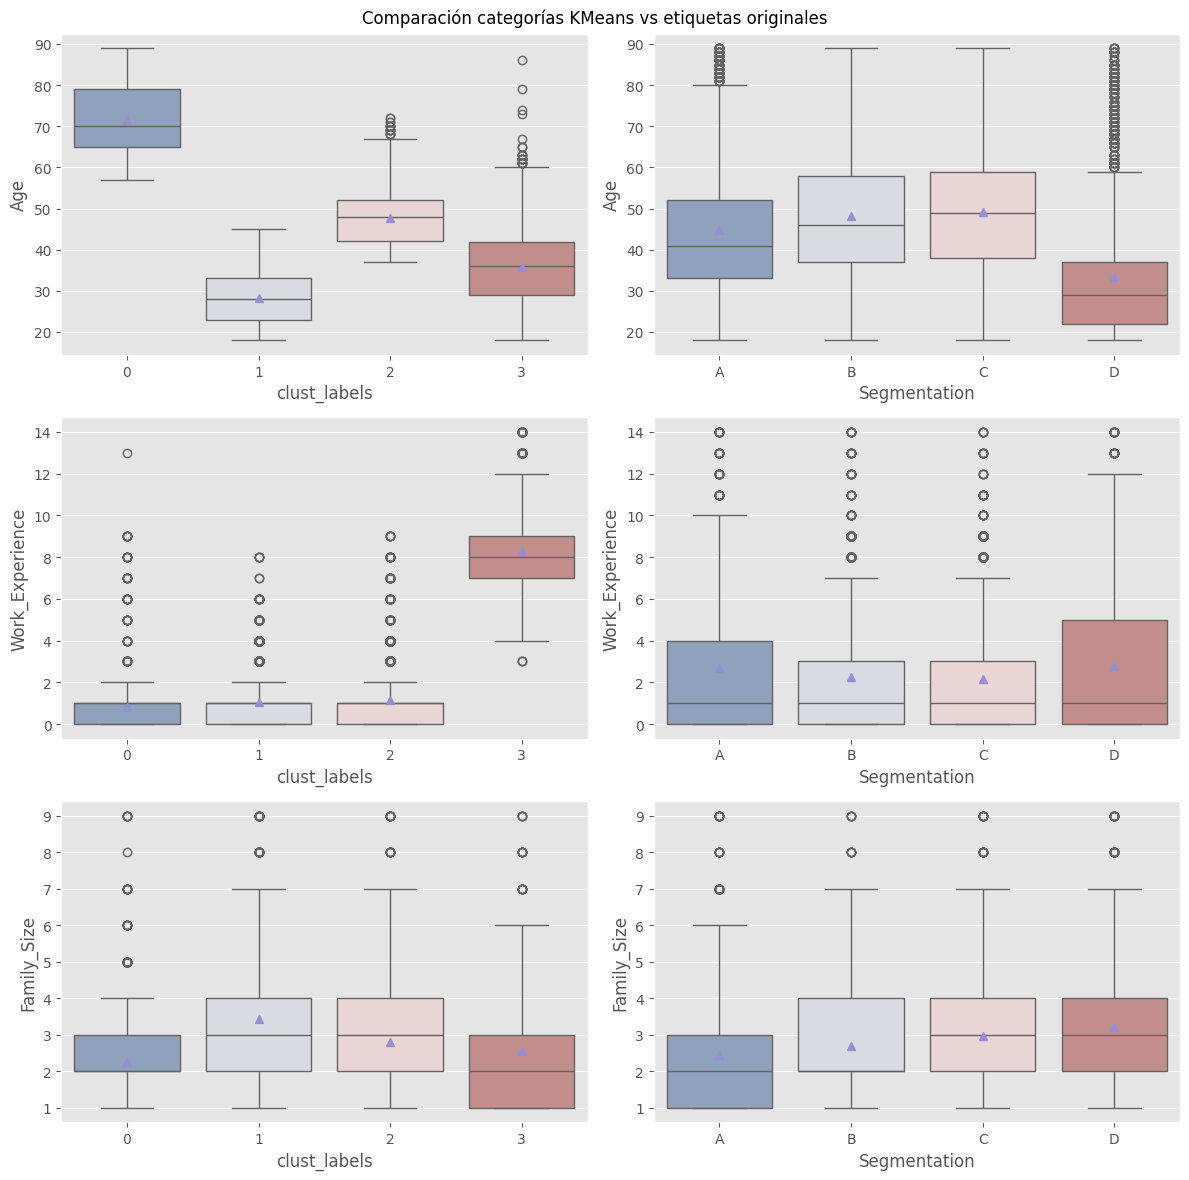

In [97]:
fig, ((ax1 ,ax2),
      (ax3, ax4),
      (ax5,ax6)) = plt.subplots(3,2, figsize = (12,12))
sns.boxplot(data = trainClust, x = 'Segmentation', y = 'Age',order = trainClust.Segmentation.sort_values().unique(), ax = ax2, showmeans = True, palette = 'vlag')
sns.boxplot(data = trainClust, x = 'clust_labels', y = 'Age',order = trainClust.clust_labels.sort_values().unique(),ax = ax1 ,showmeans = True, palette = 'vlag')
sns.boxplot(data = trainClust, x = 'Segmentation', y = 'Work_Experience',order = trainClust.Segmentation.sort_values().unique(), ax = ax4, showmeans = True, palette = 'vlag')
sns.boxplot(data = trainClust, x = 'clust_labels', y = 'Work_Experience',order = trainClust.clust_labels.sort_values().unique(),ax = ax3 ,showmeans = True, palette = 'vlag')
sns.boxplot(data = trainClust, x = 'Segmentation', y = 'Family_Size',order = trainClust.Segmentation.sort_values().unique(), ax = ax6, showmeans = True, palette = 'vlag')
sns.boxplot(data = trainClust, x = 'clust_labels', y = 'Family_Size',order = trainClust.clust_labels.sort_values().unique(),ax = ax5 ,showmeans = True, palette = 'vlag')
fig.suptitle('Comparación categorías KMeans vs etiquetas originales')
plt.tight_layout()
plt.show()

**Conclusión y recomendaciones**
- Al comparar la nueva segmentación de los individuos derivada de la utilización de los métodos de PCA y KMeans, con la etiqueta original de las observaciones se encuentra que los nuevos segmentos de clientes están mejor diferenciados en la variable edad y experiencia laboral, lo que es consecuente con que estas dos variables son las que mayor aporte tienen a los dos primeros componentes principales. Por lo tanto, emplear estos métodos es una buena práctica para encontrar patrones en los datos y mejorar la clasificación de los clientes.